# Rede Neural de Múltiplas Camadas para Regressão Simbólica

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, LassoLarsCV
import warnings
import os
import pickle

# ignoramos os resultados NaN das funções pois vamnos zera-los
np.seterr(invalid='ignore')
# nao quero warning de convergência
warnings.filterwarnings('ignore')

In [9]:
def getResults(fname='results.pkl'):
    dataset = []
    algoritmo = []
    ninter_l = []
    inter_min_l  = []
    inter_max_l  = []
    msre_l = []
    if os.path.exists(fname):
        fw = open(fname, 'rb')
        dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l  = pickle.load(fw)
        fw.close()
    return dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l

In [10]:
def storeResults(dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l, fname='results.pkl'):
    fw = open(fname, 'wb')
    pickle.dump((dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l), fw)
    fw.close()

- calcula mean square root error

In [11]:
def msre(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

- carrega os dados do arquivo fname e retorna X, y

In [2]:
def importaDados(fname):
    dataset = np.loadtxt(fname, delimiter=",")
    X = dataset[:, :-1]
    y = dataset[:, -1]
    return (X, y)

- gera a rede de expoentes entre inter_min (incl) e inter_max (excl)
- para todo atributo da base que contém algum zero na coluna, o expoente correspondente é alterado para o valor absoluto dele a fim de não fazer 1/0, pois gerava alguns Inf que fazia com que a base toda ficasse 0 por padrão.

In [6]:
def geraRede(X, n_inter, inter_min=0, inter_max=3):
    n_inputs = X.shape[1]
    rede = np.random.randint(inter_min, inter_max, size=(n_inputs, n_inter))
    for i in range(0, n_inputs):
        if 0 in X[:,i]:
            rede[i,:] = np.absolute(rede[i,:])
    return rede

- recebe uma matriz X e uma rede de expoentes
- retorna os dados transformados
- substitui todos os valores NaN e Inf para 0

In [12]:
def transformData(X, rede):
    n_rows = X.shape[0]
    n_inter = rede.shape[1]
    layers = np.ndarray((n_rows, 3*n_inter))
    for i in range(0, n_inter*3, 3):
        power = X**rede[:,int(i/3)]
        layers[:,i] = np.prod(power,axis=1) # id
        layers[:,i+1] = np.cos(layers[:,i]) # cos
        layers[:,i+2] = np.sqrt(layers[:,i]) # sqrt
    cols = np.any(np.isnan(layers), axis=0)
    layers[:, cols] = 0
    cols = np.any(np.isinf(layers), axis=0)
    layers[:, cols] = 0
    return layers

- Cria a camada de expoentes da rede com n_inter neurônios
- Aplica a função transformData em X_train utilizando essa rede
- Divida a base entre treino e validação
- Aplique o LassoCV e LassoLarsCV, verifique na validação o que retorna o menor erro
- Retorne a rede e o modelo de menor erro
- expoentes aleatorios de 0 a 2

In [13]:
def fit(X, y, n_inter, inter_min=0, inter_max=3):
    n_inputs = X.shape[1]
    rede = geraRede(X, n_inter, inter_min, inter_max)
    X_transf = transformData(X, rede)
    lasso = LassoCV(max_iter=5e4, cv=3)
    lassoLars = LassoLarsCV(max_iter=5e4, cv=3)
    lasso.fit(X_transf, y)
    lassoLars.fit(X_transf, y)
    return rede, lasso, lassoLars

- Aplica transformData em X_test usando a rede
- Aplique o método predict de modelo na base transformada e armazena a saída em y_hat
- Retorna y_hat

In [14]:
def predict(X, rede, modelo):
    X_transf = transformData(X, rede)
    y_hat = modelo.predict(X_transf)
    return y_hat

- main

In [42]:
dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l = getResults('results.pkl')

In [16]:
algoritmos = ['lasso', 'lassoLars']
ninter_list = [10, 50, 100]
inter_min_max = [(-1,1), (-2,2), (-3,3), (-4,4), (-5,5), (0,1), (0,2), (0,3), (0,4), (0,5)]
pastas = ['0', '1', '2', '3', '4']
#bases = ['airfoil', 'concrete', 'cpu', 'energyCooling', 'energyHeating', 'forestfires', 'towerData', 'wineRed', 'wineWhite', 'yacht']
#basesquebugam = ['bioavailability', 'ppb']

In [35]:
#for D in bases:
D = 'bioavailability'
#for ninter in ninter_list:
ninter = 10
for (inter_min, inter_max) in inter_min_max:
    dataset += [D, D]
    ninter_l += [ninter, ninter]
    inter_min_l += [inter_min, inter_min]
    inter_max_l += [inter_max, inter_max]
    algoritmo += ['lasso', 'lassoLars']
    msre_lasso = 0
    msre_lassoLars = 0
    for pasta in pastas:
        fileTrain = 'datasets/' + D + '-train-' + pasta + '.dat'
        X, y = importaDados(fileTrain)
        n = X.shape[1]
        X_treino, X_validacao, y_treino, y_validacao = train_test_split(X, y, test_size=0.3, random_state=1)
        rede, lasso, lassoLars = fit(X_treino, y_treino, ninter*n, inter_min, inter_max+1)
        y_lasso = predict(X_validacao, rede, lasso)
        y_lars = predict(X_validacao, rede, lassoLars)
        msre_lasso += msre(y_validacao, y_lasso)
        msre_lassoLars += msre(y_validacao, y_lars)
    m = len(pastas)
    msre_l += [msre_lasso/m, msre_lassoLars/m]

ValueError: x and y arrays must have at least 2 entries

In [ ]:
storeResults(dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l, 'results.pkl')

In [43]:
dataframe = {'dataset':dataset, 
             'algoritmo':algoritmo, 
             'ninter': ninter_l, 
             'inter_min':inter_min_l, 
             'inter_max':inter_max_l, 
             'msre':msre_l}
df = pd.DataFrame(dataframe)
fw = open('df.pkl', 'wb')
pickle.dump(df, fw)
fw.close()

In [ ]:
fw = open('df.pkl', 'rb')
df = pickle.load(fw)
fw.close()

In [44]:
df

,algoritmo,dataset,inter_max,inter_min,msre,ninter
0,lasso,airfoil,1,-1,6.228973,10
1,lassoLars,airfoil,1,-1,3.715972,10
2,lasso,airfoil,2,-2,6.706637,10
3,lassoLars,airfoil,2,-2,2.897756,10
4,lasso,airfoil,3,-3,6.830836,10
5,lassoLars,airfoil,3,-3,3.227055,10
6,lasso,airfoil,4,-4,6.846473,10
7,lassoLars,airfoil,4,-4,3.489496,10
8,lasso,airfoil,5,-5,6.855335,10
9,lassoLars,airfoil,5,-5,4.193533,10


### Análise pro airfoil

- algoritmo = lassoLars
- n_inter = 10
- inter_min_max = -2, 2

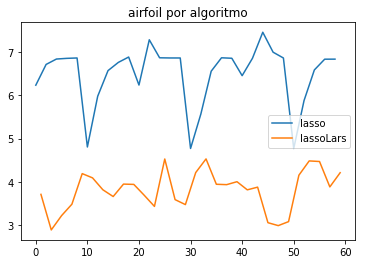

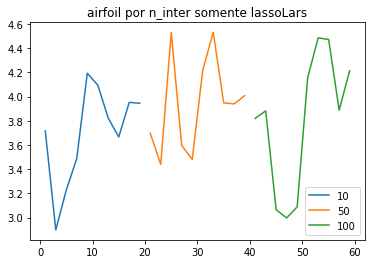

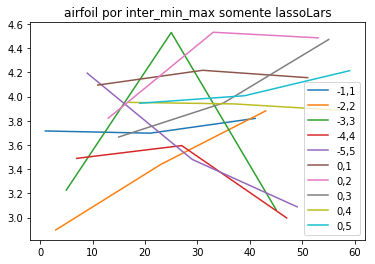

In [33]:
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'airfoil'].loc[df['algoritmo'] == algoritmo]['msre']
    S.plot(title='airfoil por algoritmo', label=algoritmo, legend=True)
plt.show()
for ninter in ninter_list:
    S = df.loc[df['dataset'] == 'airfoil'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] == ninter]['msre']
    S.plot(title='airfoil por n_inter somente lassoLars', label=ninter, legend=True)
plt.show()
for inter_min, inter_max in inter_min_max:
    S = df.loc[df['dataset'] == 'airfoil'].loc[df['algoritmo'] == 'lassoLars'].loc[df['inter_min'] == inter_min].loc[df['inter_max'] == inter_max]['msre']
    S.plot(title='airfoil por inter_min_max somente lassoLars', label=f'{inter_min},{inter_max}', legend=True)
plt.show()

### Análise pro concrete

- algoritmo = lassoLars
- n_inter = 10
- inter_min_max = 0, 1

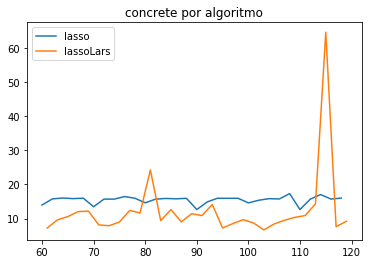

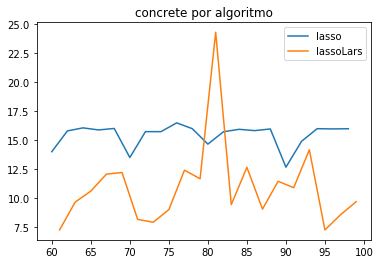

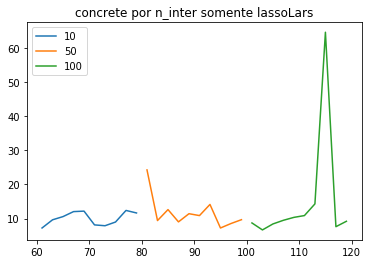

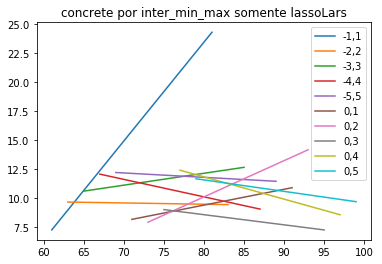

In [41]:
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == algoritmo]['msre']
    S.plot(title='concrete por algoritmo', label=algoritmo, legend=True)
plt.show()
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == algoritmo].loc[df['ninter'] != 100]['msre']
    S.plot(title='concrete por algoritmo', label=algoritmo, legend=True)
plt.show()
for ninter in ninter_list:
    S = df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] == ninter]['msre']
    S.plot(title='concrete por n_inter somente lassoLars', label=ninter, legend=True)
plt.show()
for inter_min, inter_max in inter_min_max:
    S = df.loc[df['dataset'] == 'concrete'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] != 100].loc[df['inter_min'] == inter_min].loc[df['inter_max'] == inter_max]['msre']
    S.plot(title='concrete por inter_min_max somente lassoLars', label=f'{inter_min},{inter_max}', legend=True)
plt.show()

### Análise pro cpu

- algoritmo = lassoLars
- n_inter = 10
- inter_min_max = -1, 1

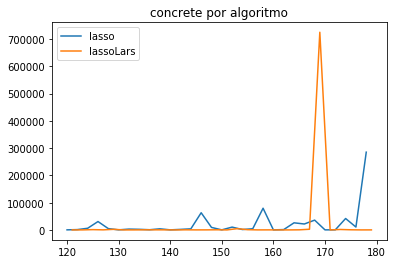

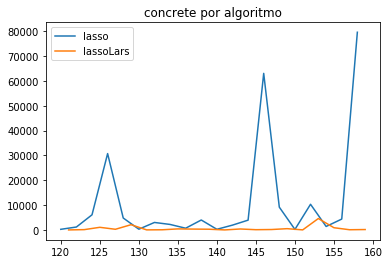

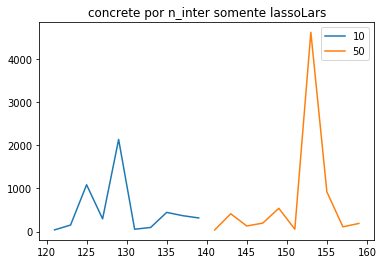

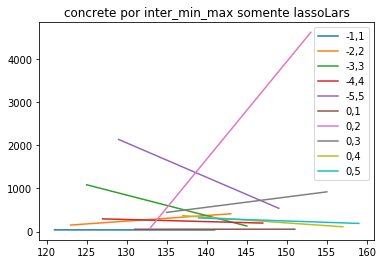

In [48]:
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == algoritmo]['msre']
    S.plot(title='concrete por algoritmo', label=algoritmo, legend=True)
plt.show()
for algoritmo in algoritmos:
    S = df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == algoritmo].loc[df['ninter'] != 100]['msre']
    S.plot(title='concrete por algoritmo', label=algoritmo, legend=True)
plt.show()
for ninter in ninter_list:
    if ninter != 100:
        S = df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] == ninter]['msre']
        S.plot(title='concrete por n_inter somente lassoLars', label=ninter, legend=True)
plt.show()
for inter_min, inter_max in inter_min_max:
    S = df.loc[df['dataset'] == 'cpu'].loc[df['algoritmo'] == 'lassoLars'].loc[df['ninter'] != 100].loc[df['inter_min'] == inter_min].loc[df['inter_max'] == inter_max]['msre']
    S.plot(title='concrete por inter_min_max somente lassoLars', label=f'{inter_min},{inter_max}', legend=True)
plt.show()